In [3]:
from time import time, sleep
from functools import reduce

import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import BallTree, NearestNeighbors
from vincenty_cuda_nns import CudaTree
from brute_cuda import brute_cuda
from brute_cpu import brute_cpu, compiled_vincenty, plain_vincenty, stupid_cpu


plt.rcParams['figure.figsize'] = [16, 8]

In [4]:
df = gpd.read_file('datasets/points_1kk.geojson')
X = np.stack(df['geometry']).astype(np.float32)
X

array([[ 30.32682419,  50.38022614],
       [ 30.15469742,  50.50265884],
       [ 31.06276703,  50.3793869 ],
       ..., 
       [ 30.46461868,  50.41419601],
       [ 30.3853302 ,  50.47689819],
       [ 30.51917267,  50.40744781]], dtype=float32)

In [5]:
TIME_LIMIT = 1
LEN_LIMIT = len(X)
ABS_TIME_LIMIT = 600

In [6]:
def test_func(func, name):
    data = [{'len': 0, name: 0}]

    t0 = time()

    for i in range(500, LEN_LIMIT, 500):
        try:
            t1 = time()
            func(X[:i])
            t3 = time()
    
            data.append({
                'len': i,
                name: t3 - t1,
            })
        
            if (ABS_TIME_LIMIT > 0) and ((t3 - t0) > ABS_TIME_LIMIT):
                print('Reached absolute limit')
                break
                
            if (TIME_LIMIT > 0) and ((t3 - t1) > TIME_LIMIT):
                print('Reached time limit')
                break
                
        except Exception as err:
            print(err)
            break
    else:
        print('Reached lenght limit')
 
    return pd.DataFrame(data)

In [7]:
def sk_parallel(data):
    nn_searcher = NearestNeighbors(
        algorithm='ball_tree',
        metric=compiled_vincenty,
        n_jobs=-1,
        leaf_size=5
    ).fit(data)

    nn_searcher.kneighbors_graph(data, n_neighbors=1, mode='distance')
    
def sk_plain(data):
    bt = BallTree(data, leaf_size=5, metric=plain_vincenty)
    bt.query(data, 2)
    
def sk_ball_tree(data):
    bt = BallTree(data, leaf_size=5, metric=compiled_vincenty)
    bt.query(data, 2)

def cuda_tree(data):
    cuda_tree = CudaTree(data, leaf_size=5)
    cuda_tree.query(n_neighbors=2)
    
sk_parallel(X[:10])
sk_ball_tree(X[:10])
cuda_tree(X[:10])

In [8]:
print('Sklearn no compilation')
df0 = test_func(sk_plain, 'sklearn_plain')
sleep(1)

print('Brute CPU no compilation')
df1 = test_func(stupid_cpu, 'stupid_cpu')
sleep(1)

print('Sklearn parallel compiled')
df2 = test_func(sk_parallel, 'sklearn_parallel')
sleep(1)

print('Sklearn ball tree compiled')
df3 = test_func(sk_ball_tree, 'sklearn_ball_tree')
sleep(1)

print('Brute GPU')
df4 = test_func(brute_cuda, 'brute_gpu')
sleep(1)

print('Brute CPU compiles')
df5 = test_func(brute_cpu, 'brute_cpu')
sleep(1)

print('CUDA tree')
df6 = test_func(cuda_tree, 'numba_ball_tree_gpu')
sleep(1)

Sklearn no compilation
Reached time limit
Brute CPU no compilation
Reached time limit
Sklearn parallel compiled
Reached time limit
Sklearn ball tree compiled
Reached time limit
Brute GPU
Reached time limit
Brute CPU compiles
Reached time limit
CUDA tree
Reached time limit


In [9]:
dfs = [df0, df1 , df2 , df3 , df4 , df5 , df6]
df_final = reduce(lambda left, right: pd.merge(left, right, on='len', how='outer'), dfs)

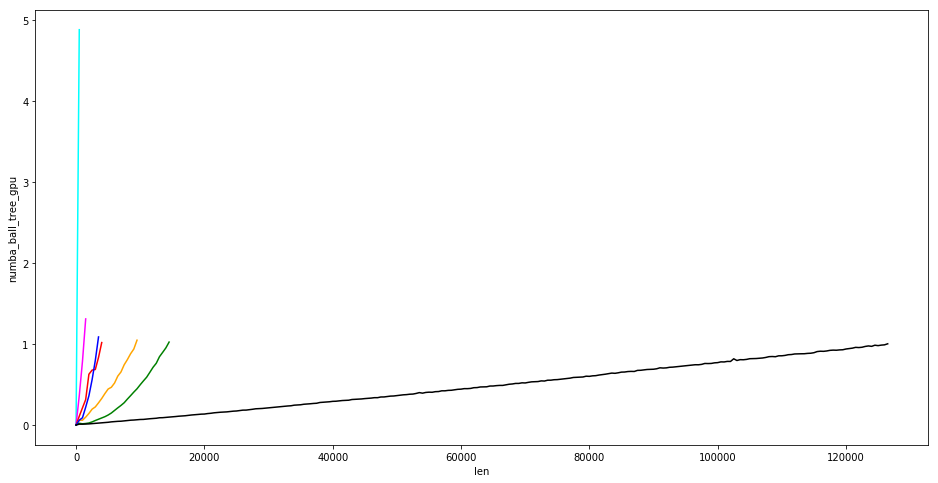

In [10]:
sns.lineplot(x='len', y='stupid_cpu', data=df_final, color='cyan')
sns.lineplot(x='len', y='sklearn_plain', data=df_final, color='magenta')
sns.lineplot(x='len', y='sklearn_parallel', data=df_final, color='red')
sns.lineplot(x='len', y='sklearn_ball_tree', data=df_final, color='orange')
sns.lineplot(x='len', y='brute_gpu', data=df_final, color='green')
sns.lineplot(x='len', y='brute_cpu', data=df_final, color='blue')
sns.lineplot(x='len', y='numba_ball_tree_gpu', data=df_final, color='black')